In [24]:
import yfinance as yf
import pandas as pd
import matplotlib as plt

In [25]:
sp500 = yf.Ticker("^GSPC")

sp500 = sp500.history(period="max")

In [32]:
del sp500["Dividends"], sp500["Stock Splits"]
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2022-08-04,4154.850098,4161.290039,4135.419922,4151.939941,3565810000,4145.189941,0
2022-08-05,4115.870117,4151.580078,4107.310059,4145.189941,3540260000,4140.060059,0
2022-08-08,4155.930176,4186.620117,4128.970215,4140.060059,3604650000,4122.470215,0


In [27]:
sp500.index

DatetimeIndex(['1950-01-03', '1950-01-04', '1950-01-05', '1950-01-06',
               '1950-01-09', '1950-01-10', '1950-01-11', '1950-01-12',
               '1950-01-13', '1950-01-16',
               ...
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10'],
              dtype='datetime64[ns]', name='Date', length=18270, freq=None)

<AxesSubplot:xlabel='Date'>

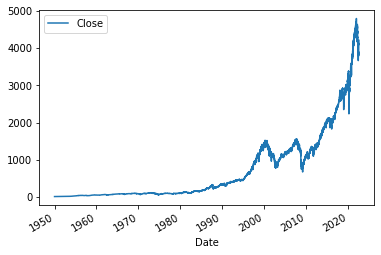

In [28]:
sp500.plot.line(y="Close", use_index=True)

In [29]:
# Append new column with the following day's closing price
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [30]:
# Append new column called target which returns directionality (1 is positive, 0 is negative)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [33]:
# Truncate data set
sp500 = sp500.loc["1990-01-01":].copy()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2022-08-04,4154.850098,4161.290039,4135.419922,4151.939941,3565810000,4145.189941,0
2022-08-05,4115.870117,4151.580078,4107.310059,4145.189941,3540260000,4140.060059,0
2022-08-08,4155.930176,4186.620117,4128.970215,4140.060059,3604650000,4122.470215,0


In [38]:
# Implement RandomForestClassifier to detect nonlinear patterns
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier fits n-decision tree classifiers on sub-sampels of data and uses 
# averaging improve predictive accuracy and control over-fitting.
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)
# n_estimators : number of trees in the forest; the higher it is, the more accurate
# min_samples_split : the minimum number of samples required to split an internal node; helps counter overfitting, higher = less accurate, less overfitting
# random_state : controls for randomization so that our model is consistent

# Our data is time series data, which eliminates the usage of cross-validation (model would leak - use future data to predict older data)

# train the model with the all the datapoints up to the last 100
train = sp500.iloc[:-100]
# test the model with the last 100 data points
test = sp500.iloc[-100:]


# Create a list of the columns we use to predict the target
# Tomorrow column can't be used because the model would then know information about the future that it could not know
predictors = ["Close", "Volume", "Open", "High", "Low"]
# Fit the model, try to predict the target
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [43]:
# Measure your model's accuracy
from sklearn.metrics import precision_score

# What % of the time did the market go up when we predicted it would go up?
ps = model.predict(test[predictors])
# ps yields a numpy array, which is harder to work with that pandas, so we pivot
ps = pd.Series(ps, index=test.index)
ps

Date
2022-03-18    0
2022-03-21    0
2022-03-22    1
2022-03-23    1
2022-03-24    1
             ..
2022-08-04    1
2022-08-05    1
2022-08-08    1
2022-08-09    1
2022-08-10    0
Length: 100, dtype: int64

In [45]:
# Calcuate the precision score using the expected target and the actual target
precision_score(test["Target"], ps)

## This model produces ~47% accuracy in predicting the price increases. Not good.

0.47560975609756095

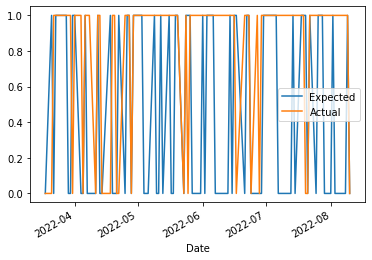

In [59]:
# Plot predictions - combine expected and actual values with pandas concat()
combined = pd.concat([test["Target"], ps], axis=1)
combined.plot().legend(['Expected', 'Actual'])

## Resulting plot shows that we often predicted the market to go up, but it often went down. Bad.

In [67]:
# Building more robust testing
# Create prediction function to wrap everything into one func
def predict(train,test,predictors,model):
    model.fit(train[predictors], train["Target"])
    ps = model.predict(test[predictors])
    ps = pd.Series(ps, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"],ps], axis=1)
    return combined

In [68]:
# Create backtest function
# Parameters: sp500 data, machine learning model, our predictors, and start and step values
# Start value: need a certain amount of data to train model the model. Every trading year has ~250 trading days, so we want to take 10 years of data for training 
# Step value: 250 step means we will take a year's data and predict the next year, then repeat the process
def backtest(data, model, predictions, start = 2500, step = 250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train,test,predictors,model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [71]:
predictions = backtest(sp500, model, predictors)

In [72]:
# How many times did our mondel predict an increase vs decrease
predictions["Predictions"].value_counts()

0    3336
1    2380
Name: Predictions, dtype: int64

In [73]:
# How accurate was our model
precision_score(predictions["Target"],predictions["Predictions"])

0.5352941176470588

In [74]:
# 53% accuracy (not good)
# How many days did the market go up
predictions["Target"].value_counts() / predictions.shape[0]

1    0.536214
0    0.463786
Name: Target, dtype: float64

In [77]:
# Above shows that the market actually went up 54% of days, so our model is less accurate than picking heads only in a coin toss could be :/
# This means that we need to incorporate more data/constraints (e.g. - is the stock price higher now than n days ago)
# horizons - rolling averages/means on close prices for different time frames (# of days) 
horizons = [2,5,60,250,1000] # 2 days, 1 trading week, a few months, a trading year, etc
new_predictors = []

# Loop through horizons and take rolling averages against the horizon, then take the mean
for horizon in horizons:
    roll_avg = sp500.rolling(horizon).mean()
    
    # Create a column of ratios bt the close and the 
    ratios = f"Close_Ratio_{horizon}" 
    # Add ratios to the sp500 dataframe
    sp500[ratios] = sp500["Close"] / roll_avg["Close"]
    # First loop iteration would be the ratio bt today's close & the avg close the last two days
    # From there, today's close vs the avg close the last 5 days, then 60, ... 
    
    # We need to look for a trend(number of days based on horizon that the stock actually went up)
    # We will use the Target col in the data and take the sum of days that the stock DID go up
    trend = f"Trend_{horizon}"
    sp500[trend] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    # Create new predictors
    new_predictors += [ratios,trend]

In [78]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-04,4154.850098,4161.290039,4135.419922,4151.939941,3565810000,4145.189941,0,0.999611,1.0,1.005448,2.0,1.052970,29.0,0.952400,126.0,1.181632,548.0
2022-08-05,4115.870117,4151.580078,4107.310059,4145.189941,3540260000,4140.060059,0,0.999186,0.0,1.003089,1.0,1.050618,28.0,0.951103,126.0,1.179266,548.0
2022-08-08,4155.930176,4186.620117,4128.970215,4140.060059,3604650000,4122.470215,0,0.999381,0.0,1.000810,1.0,1.048411,28.0,0.950184,125.0,1.177371,547.0


In [79]:
# Above, we see that there are a lot of NaN's the in new predictors. 
# This happens of course when there are two few days for one of the horizon iterations to calculate a ratio or trend. 
# For this, we only need to show data from the moment we can actually get ratios and trends.

sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-03,4107.959961,4167.660156,4107.959961,4155.169922,3544410000,4151.939941,0,1.007759,1.0,1.010120,3.0,1.054506,29.0,0.952893,127.0,1.182993,549.0
2022-08-04,4154.850098,4161.290039,4135.419922,4151.939941,3565810000,4145.189941,0,0.999611,1.0,1.005448,2.0,1.052970,29.0,0.952400,126.0,1.181632,548.0
2022-08-05,4115.870117,4151.580078,4107.310059,4145.189941,3540260000,4140.060059,0,0.999186,0.0,1.003089,1.0,1.050618,28.0,0.951103,126.0,1.179266,548.0


In [92]:
# Notice now how the data begins in 1993. It begins essentially ~1000 days after the start of the data, once our ratios and trends are calculable.
# How can we improve our model? 
# Changing randomforestclassifier parameters
model = RandomForestClassifier(n_estimators=500, min_samples_split=50, random_state=1)

In [93]:
# Our predict func from earlier only returns 0 or 1, but we want more control over what becomes a 0 and what becomes a 1
# We can use predict_proba to grab a probability of if the stock price 
# will increase or decrease, and with a custom threshold
def predict(train,test,predictors,model):
    model.fit(train[predictors], train["Target"])
    # Probability that the stock price will go up/down tomorrow.
    # [:,1] will give the probability that the stock price will go up
    ps = model.predict_proba(test[predictors])[:,1]
    # Set our threshold to 60%. 
    # Model has to be more confident that the price will go up before it says the price will go up.
    # Try 70%? 
    ps[ps >= .7] = 1
    ps[ps < .7] = 0
    ps = pd.Series(ps, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"],ps], axis=1)
    return combined

In [94]:
predictions = backtest(sp500, model, new_predictors)

In [95]:
predictions["Predictions"].value_counts()

0.0    4435
1.0     280
Name: Predictions, dtype: int64

In [96]:
# Now we see a very different picture than before, where the split was 54/46
# How accurate are we at this point? 
per_acc = (precision_score(predictions["Target"],predictions["Predictions"])*100).round(2)
print(f"{per_acc}%")

# At this point, this is mediocre. You will net profit, but barely, it seems.

57.86%


In [ ]:
# Think further:
# Overnight exchanges (international indices which trade on different timeframes than the US market only)
# Crypto-currencies have a lot more data because they have trading 24/7
# Macroeconomic influences - recessions/inflation/interest rates, global news, etc.
# Can increase resolution (look at hourly data, expensive though)

# We could alter the code in some ways:
# We could decrease step size to increase how much data we look at, but can get expensives
# Research more predictors

